In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# config
base_input_path = './input/'
input_path = f'{base_input_path}'
output_path = './output/'

# visualise

In [3]:
metadata = pd.read_csv(f'{base_input_path}metadata.csv')
species_names = pd.read_csv(f'{base_input_path}species_names.csv')

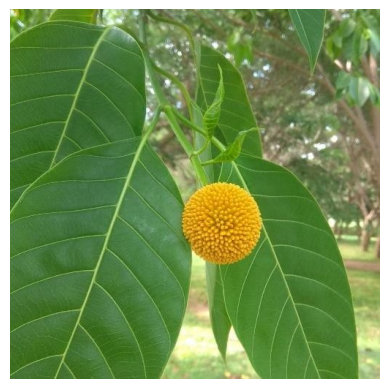

In [4]:
def show_image(path):
    img = Image.open(f'{input_path}{path}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_tensor_image(tensor):
    tensor = tensor.detach().numpy().transpose((1, 2, 0))
    plt.imshow(image_array)
    plt.axis('off')  # To hide axis values
    plt.show()
    
show_image('train/1409834/0e244e0fcee6fda46e75e991ba872b1c6ae56359.jpg')

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306146 entries, 0 to 306145
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            306146 non-null  object
 1   species_id    306146 non-null  int64 
 2   obs_id        306146 non-null  int64 
 3   organ         306146 non-null  object
 4   is_shareable  306146 non-null  bool  
 5   v1_id         37024 non-null   object
 6   author        306146 non-null  object
 7   license       306146 non-null  object
 8   split         306146 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 19.0+ MB


In [6]:
metadata.head()

,id,species_id,obs_id,organ,is_shareable,v1_id,author,license,split
0,6033c318d5678da896eae5ae54ac60f71e5286bf,1391810,1008601284,leaf,True,NaN,Heribert Zimmermann,cc-by-sa,val
1,66d6455735fbdc582629dfc58940d9f409c7a9b3,1363021,1005119570,flower,True,NaN,Jimenez Melissa,cc-by-sa,val
2,1a5c3ffe9142f29df7fb56fc519764a457e8d01d,1398567,1004431075,leaf,True,NaN,Lisa,cc-by-sa,val
3,e86c71b84e97af16307801a1b986269fb4243fc1,1362954,1008006449,leaf,True,NaN,Pasqualotto Rossella,cc-by-sa,val
4,8f954427dfbf8853bf8d655fa9bdda2801ebc025,1359498,1006017920,flower,True,NaN,Elizabeth Roy,cc-by-sa,test


In [7]:
species_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   species_id    1081 non-null   int64 
 1   species_name  1081 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


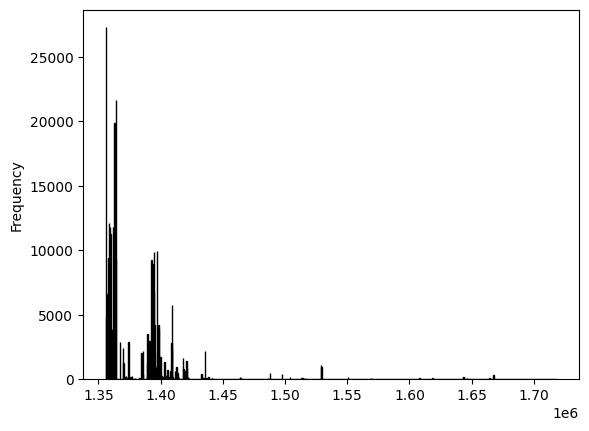

In [8]:
metadata['species_id'].plot(kind='hist', edgecolor='black', bins=1081)
# plt.xlabel('speci')
plt.ylabel('Frequency')
plt.show()

# helpers

In [9]:
import torch
import os
import random

plt.style.use('ggplot')

best_model_path = f'best_model.pth'

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss >= self.best_valid_loss:
            return

        self.best_valid_loss = current_valid_loss
        print(f"\nBest validation loss: {self.best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch+1}\n")
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
        }, best_model_path)
        

def load_best_model():
    return torch.load(best_model_path)

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, f'{output_path}models/model_{epoch}.pth')



def show_species_sample(species_id):
    # List all files in the directory
    directory_path = f"{input_path}train/{species_id}/"
    all_files = os.listdir(directory_path)

    # Filter out any non-image files if needed (e.g., based on file extension)
    image_files = [f for f in all_files if f.lower().endswith(('jpg'))]

    # Select a random image file
    random_image_file = random.choice(image_files)

    # Open and display the image
    image_path = os.path.join(directory_path, random_image_file)
    image = Image.open(image_path)
#     plt.imshow(image)
#     plt.axis('off')  # Hide the axis values
#     plt.show()
    return image


# load model and data  

In [10]:
import torchvision.datasets as datasets
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    transforms.RandomCrop(224) #random on training, center on validation
])


valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    transforms.CenterCrop(224)
])

train_dataset = datasets.ImageFolder(
    root=f'{input_path}train/',
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=f'{input_path}test/',
    transform=valid_transform
)


In [11]:
from torch.utils.data import DataLoader, Subset

batch_size = 32
subset = None
train_subset = None
test_subset = None

# subset for quick iteration, disable once tested
# this is probably class imbalanced due to the nature of Subset not taking a stratified sample, but it is probably good enough for now.
# additionally, the way the test_dataset is subset is naive and may not be a good comparison size relative to train_dataset. i.e. 
# the subset should probably be a percentage, rather than a fixed number
if subset is not None:
    print(f"subsetting data to {subset} results")
    train_subset_indices = list(range(subset if subset < len(train_dataset) else len(train_dataset)))
    train_subset = Subset(train_dataset, train_subset_indices)

    test_subset_indices = list(range(subset if subset < len(test_dataset) else len(test_dataset)))
    test_subset = Subset(test_dataset, test_subset_indices)

# training data loaders
train_loader = DataLoader(
    train_dataset if train_subset is None else train_subset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True
)
# validation data loaders
test_loader = DataLoader(
    test_dataset if test_subset is None else test_subset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True
)

In [12]:
import torch
import torch.nn as nn
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

num_classes = len(species_names)
model.classifier[-1] = torch.nn.Linear(4096, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[6].parameters():
    param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model= nn.DataParallel(model)
model.to(device)

Using cache found in C:\Users\Rusyda/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Rusyda\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Rusyda\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DataParallel(
  (module): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
   

In [13]:
def top_k_accuracy(output, target, k=5):
    with torch.no_grad():
        # Get the top k indices (labels) predicted
        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.contiguous().view(1, -1).expand_as(pred))
        
        # Compute and return the top-k accuracy
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / output.size(0))

# def average_k_accuracy(output, target, k=5):
#     with torch.no_grad():
#         _, pred = output.max(1)
#         mask = target < k
#         correct = pred[mask].eq(target[mask])
#         return correct.float().mean().mul_(100.0)
    
def average_k_accuracy(output, target, k=5):
    with torch.no_grad():
        _, pred = output.topk(k, 1, True, True)  # Get the top-k predicted classes
        correct = pred.eq(target.view(-1, 1).expand_as(pred))  # Compare predictions to true labels
        accuracy = correct.float().mean()  # Calculate mean accuracy across all samples
        return accuracy.mul_(100.0)  # Optionally multiply by 100 to get a percentage


# todo merge below into 1 function
def macro_average_top_k_accuracy(output, target, k=5):
    accuracies = []
    for c in range(num_classes):
        mask = target == c

        if mask.sum() == 0:  # If there are no samples for the class, skip
            continue

        filtered_output = output[mask]
        filtered_target = target[mask]
        accuracy = top_k_accuracy(filtered_output, filtered_target, k)
        accuracies.append(accuracy.item())
    return sum(accuracies) / len(accuracies)

def macro_average_average_k_accuracy(output, target, k=5):
    accuracies = []
    for c in range(num_classes):
        mask = target == c

        if mask.sum() == 0:  # If there are no samples for the class, skip
            continue

        filtered_output = output[mask]
        filtered_target = target[mask]
        accuracy = average_k_accuracy(filtered_output, filtered_target, k)
        accuracies.append(accuracy.item())
    return sum(accuracies) / len(accuracies)

# def macro_metrics(output, target, k=5):
#     average_accuracies = []
#     top_accuracies = []

#     for c in range(num_classes):
#         mask = target == c

#         if mask.sum() == 0:  # If there are no samples for the class, skip
#             continue

#         filtered_output = output[mask]
#         filtered_target = target[mask]
#         top_accuracy = top_k_accuracy(filtered_output, filtered_target, k)
#         top_accuracies.append(top_accuracy.item())
#         average_accuracy = average_k_accuracy(filtered_output, filtered_target, k)
#         average_accuracies.append(average_accuracy.item())
    
#     top_average = sum(top_accuracies) / len(top_accuracies)
#     average_average = sum(average_accuracies) / len(average_accuracies)
#     return top_average, average_average
    

# training

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# only update unfrozen layers, i.e. the last one
optimizer = optim.SGD(model.module.classifier[-1].parameters(), lr=0.0001, momentum=0.9, nesterov=True)

In [15]:
from tqdm.auto import tqdm

num_epochs = 7
save_best_model = SaveBestModel()
metrics = {
    "losses": [],
    "top_k_accs": [],
    "avg_k_accs": []
}
zero_correct_count = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_macro_avg_top_k_acc = 0.0
    total_macro_avg_avg_k_acc = 0.0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        average_top = macro_average_top_k_accuracy(outputs, labels)
        average_average = macro_average_average_k_accuracy(outputs, labels)
        
        if average_top != 0 and average_average != 0:
            total_macro_avg_top_k_acc += average_top
            total_macro_avg_avg_k_acc += average_average
        else:
            # todo probably need to deal with this more effectively
            zero_correct_count += 1
        
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    metrics["losses"].append(avg_loss)
    avg_macro_avg_top_k_acc = total_macro_avg_top_k_acc / len(train_loader)
    metrics["top_k_accs"].append(avg_macro_avg_top_k_acc)
    avg_macro_avg_avg_k_acc = total_macro_avg_avg_k_acc / len(train_loader)
    metrics["avg_k_accs"].append(avg_macro_avg_avg_k_acc)

    save_model(epoch, model, optimizer, criterion)
    save_best_model(
        loss, epoch, model, optimizer, criterion
    )    

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Macro-Avg Top-k Accuracy: {avg_macro_avg_top_k_acc:.5f}%, Macro-Avg Avg-k Accuracy: {avg_macro_avg_avg_k_acc:.5f}%")

save_model(num_epochs, model, optimizer, criterion)
print(f"zeros: {zero_correct_count}")

C:\Users\Rusyda\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [00:06<00:00,  1.08s/it]



Best validation loss: 6.843849182128906

Saving best model for epoch: 1

Epoch [1/7], Loss: 7.0516, Macro-Avg Top-k Accuracy: 0.15432%, Macro-Avg Avg-k Accuracy: 0.03086%


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]



Best validation loss: 5.382099628448486

Saving best model for epoch: 2

Epoch [2/7], Loss: 6.1832, Macro-Avg Top-k Accuracy: 25.32407%, Macro-Avg Avg-k Accuracy: 5.06481%


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]



Best validation loss: 2.494799852371216

Saving best model for epoch: 3

Epoch [3/7], Loss: 4.7616, Macro-Avg Top-k Accuracy: 34.59656%, Macro-Avg Avg-k Accuracy: 6.91931%


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch [4/7], Loss: 3.9302, Macro-Avg Top-k Accuracy: 39.99074%, Macro-Avg Avg-k Accuracy: 7.99815%


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]



Best validation loss: 2.2062511444091797

Saving best model for epoch: 5

Epoch [5/7], Loss: 3.3584, Macro-Avg Top-k Accuracy: 67.79762%, Macro-Avg Avg-k Accuracy: 13.55952%


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Epoch [6/7], Loss: 3.9597, Macro-Avg Top-k Accuracy: 77.28836%, Macro-Avg Avg-k Accuracy: 15.45767%


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Epoch [7/7], Loss: 3.4974, Macro-Avg Top-k Accuracy: 94.09722%, Macro-Avg Avg-k Accuracy: 18.81944%
zeros: 5


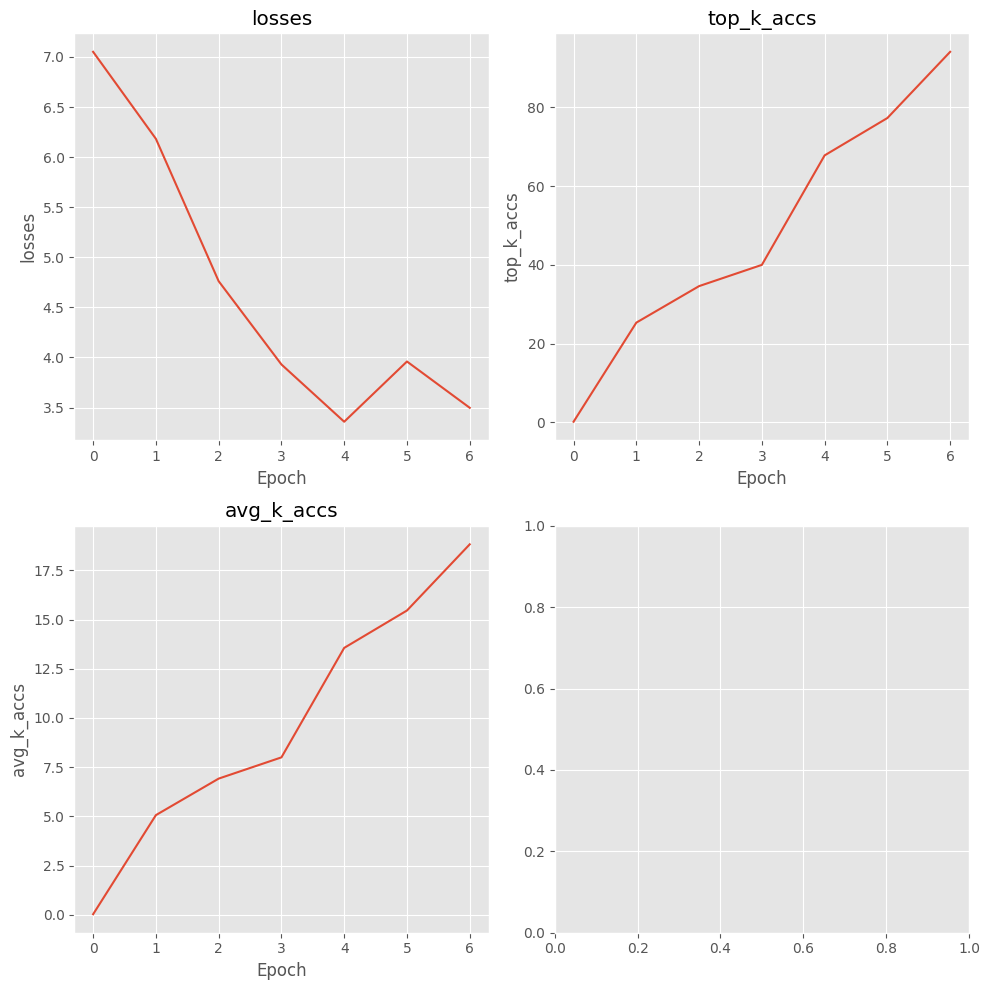

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, item in enumerate(metrics.items()):
    k, v = item
    axis = axes[i]
    axis.plot(v)
    axis.set_xlabel('Epoch')
    axis.set_ylabel(k)
    axis.set_title(k)

plt.tight_layout()
plt.show()

# test

In [17]:
inference_model = load_best_model()

C:\Users\Rusyda\AppData\Local\Temp\ipykernel_12988\3518460652.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(best_model_path)


Multiplying Loss with Batch Size:
You're scaling the loss by the batch size with loss.item() * labels.size(0). If you're looking to get the average loss per item, you'd later divide by the total number of items, not just the number of batches. It's a common approach when the test set might not be evenly divisible by the batch size. Just ensure that's your intention.

In [18]:

test_metrics = {
    "losses": [],
    "top_k_accs": [],
    "avg_k_accs": []
}
total_test_loss = 0.0
total_test_macro_avg_top_k_acc = 0.0
total_test_macro_avg_avg_k_acc = 0.0

model.eval()

temp_outputs = None
temp_labels = None
temp_issue = None

zero_correct_count = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_test_loss += loss.item() * labels.size(0)
        average_top = macro_average_top_k_accuracy(outputs, labels)
        average_average = macro_average_average_k_accuracy(outputs, labels)
        
#         if np.isnan(average_top) or np.isnan(average_average):
#             temp_outputs = outputs
#             temp_labels = labels
#             temp_issue = 'top' if np.isnan(average_top) else 'average'
#             break
        
        if average_top != 0 and average_average != 0:
            total_test_macro_avg_top_k_acc += average_top
            total_test_macro_avg_avg_k_acc += average_average
        else:
            # todo probably need to deal with this more effectively
            zero_correct_count += 1
        

avg_test_loss = total_test_loss / len(test_loader)
avg_test_macro_avg_top_k_acc = total_test_macro_avg_top_k_acc / len(test_loader)
avg_test_macro_avg_avg_k_acc = total_test_macro_avg_avg_k_acc / len(test_loader)
print(f"Loss: {avg_test_loss:.4f}, Macro-Avg Top-k Accuracy: {avg_test_macro_avg_top_k_acc:.5f}%, Macro-Avg Avg-k Accuracy: {avg_test_macro_avg_avg_k_acc:.5f}%")
print(f"zeros: {zero_correct_count}")

100%|██████████| 1/1 [00:04<00:00,  4.48s/it]

Loss: 74.2073, Macro-Avg Top-k Accuracy: 69.44444%, Macro-Avg Avg-k Accuracy: 13.88889%
zeros: 0


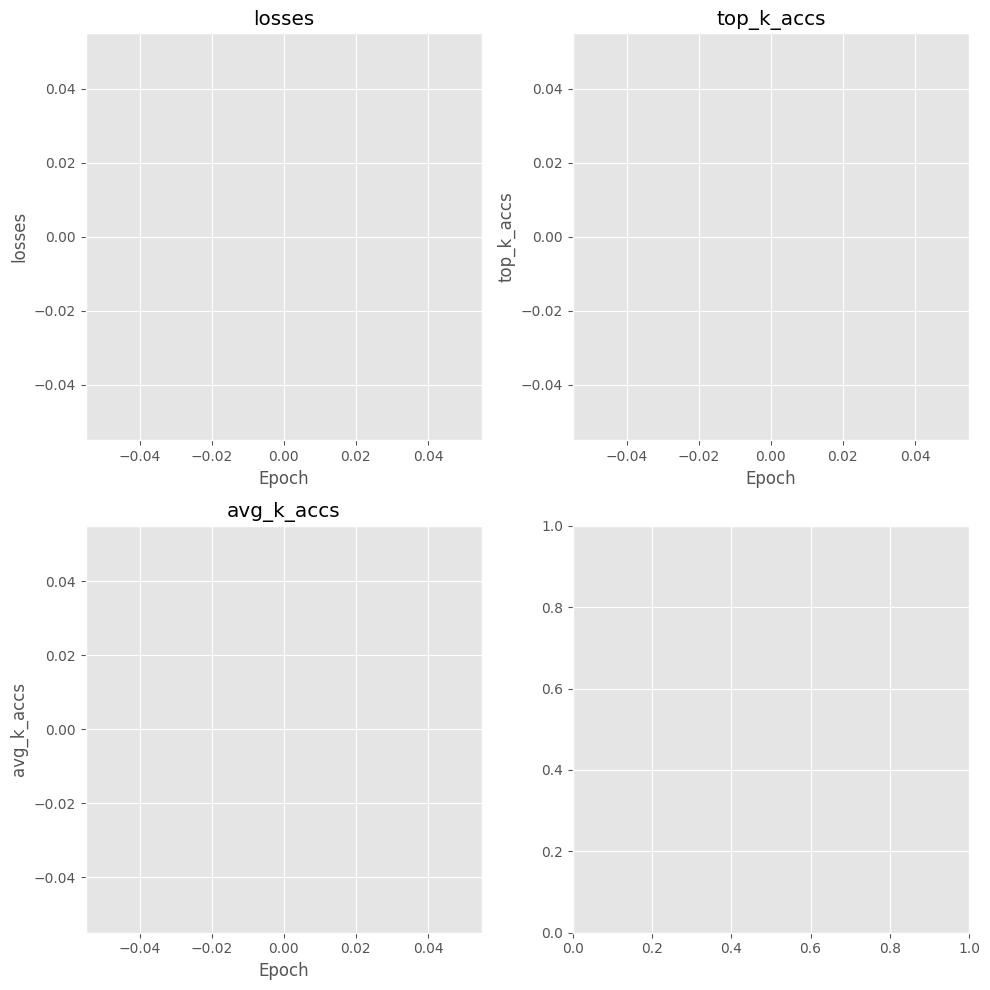

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, item in enumerate(test_metrics.items()):
    k, v = item
    axis = axes[i]
    axis.plot(v)
    axis.set_xlabel('Epoch')
    axis.set_ylabel(k)
    axis.set_title(k)

plt.tight_layout()
plt.show()

# inference

Actual species: Neolamarckia_cadamba
predicted species (1st highest probability): ['Barringtonia_asiatica', 'Neolamarckia_cadamba', 'Phyllanthus_emblica', 'Acacia_mangium', 'Acacia_auriculiformis']


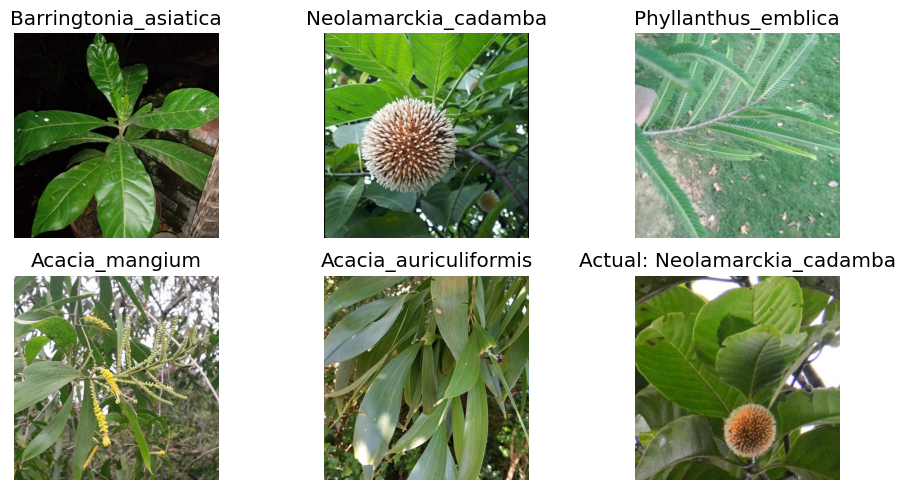

In [25]:
# show an image and predictions
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

input_species_id = 1409834
input_image = Image.open(f'input/val/1409834/58198e2a87ef54a0db1a53a58a97af67a941f1ab.jpg')
input_species_name = species_names.loc[species_names['species_id'] == input_species_id]['species_name'].iloc[0]
input_tensor = valid_transform(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

model.eval()

from torchvision import models

# Convert the model to TorchScript
example_input = torch.rand(1, 3, 224, 224)  # Contoh input dengan ukuran sesuai AlexNet
traced_script_module = torch.jit.trace(model, example_input)

# Save the TorchScript model
traced_script_module.save("best_model_android.pt")

with torch.no_grad():
    input_batch = input_batch.to(device)
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_indices = output.topk(5, 1, True, True)

images = {}
predicted_species_names = []

for idx in predicted_indices.indices[0]:
    predicted_class = int(idx_to_class[idx.cpu().item()])
    species_name = species_names.loc[species_names['species_id'] == predicted_class]['species_name'].iloc[0]
    images[species_name] = show_species_sample(predicted_class)
    predicted_species_names.append(species_name)

print(f"Actual species: {input_species_name}")
print(f"predicted species (1st highest probability): {predicted_species_names}")

fig, axarr = plt.subplots(2, 3, figsize=(10, 5))
axarr = axarr.flatten()

for i, item in enumerate(images.items()):
    key, img = item
    ax = axarr[i]
    ax.set_title(key)
    ax.imshow(img)
    ax.axis('off')

ax = axarr[-1]
ax.axis('off')
ax.set_title(f'Actual: {input_species_name}')
ax.imshow(input_image)
plt.tight_layout()
plt.show()